In [3]:
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
# import multiprocessing
# from gensim.models import Word2Vec
from openTSNE import TSNE
from fdict import sfdict
from tqdm import tqdm
from sklearn.decomposition import PCA
from collections import Counter 
import re 

In [42]:
def keep_words_with_underscore(input_string):
    # Define a regular expression pattern to match words with underscores
    pattern = r'\b\w*_[\w_]*\b'

    # Use re.findall to extract words that match the pattern
    matching_words = re.findall(pattern, input_string)

    # Join the matching words to form the final string
    result = ' '.join(matching_words)

    return result


def update_co_occurrences(word_year_list,word_co_occurrences):
    # Iterate through the words in the list
    word_list = word_year_list[0]
    year = word_year_list[1]
    
    for word in word_list:
        # If the word is not already in the dictionary, add it with an empty list
        if word not in word_co_occurrences:
            word_co_occurrences[word] = {}
        
        # Add words from the list to the co-occurrence list for the current word
        for other_word in word_list:
            # if other_word != word and other_word not in word_co_occurrences[word]:
            #     word_co_occurrences[word].append(other_word)
            if other_word != word and other_word not in word_co_occurrences[word]:
                word_co_occurrences[word][other_word] = [year] 
            
            elif other_word != word and other_word in word_co_occurrences[word]:
                # word_co_occurrences[word][other_word][0] +=1
                word_co_occurrences[word][other_word].append(year)

In [5]:
ngram_abstracts = np.load("files/ngram_abstracts.npy", mmap_mode="r")
concept_arr = np.unique(np.load("files/overlapping_concepts.npy"))
concept_filtered_arr = np.load("files/overlapping_filtered_concepts.npy")
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
month_arr = np.load("files/month_arr.npy", mmap_mode="r")

Load Co-Occur

In [17]:
phys_filtered_concept_dict = {k:1 for k in concept_filtered_arr}
ocurr_arr = []
for abstract, year in zip(ngram_abstracts, year_arr):
    temp = keep_words_with_underscore(abstract)
    if temp.count(" ") > 0:
        temp = temp.split(" ") 
        temp = [s for s in temp if s in phys_filtered_concept_dict]
        ocurr_arr.append([list(filter(("_").__ne__, temp)),year])

                        
word_co_occurrences = {}

for word_list in tqdm(ocurr_arr):
    update_co_occurrences(word_list,word_co_occurrences)



100%|██████████| 152310/152310 [00:06<00:00, 22404.65it/s]


In [43]:
# Concepts which cooccur after 2021 
cnt = 0 
c_arr = []
for concept, v in word_co_occurrences.items():
    for co_concept, year_arr in v.items():
        if np.min(year_arr) >= 2021:
            c_arr.append([concept,co_concept])
            cnt += 1 
cnt


889874

ground_state 500
quantum_phase_transition 473
phase_diagram 366
mean_field 249
steady_state 241
bose_einstein_condensate 226
entanglement_entropy 218
magnetic_field 201
thermodynamic_limit 193
hubbard_model 178
long_range 175
ising_model 174
topological_phase 169
optical_lattice 168
quantum_system 158
symmetry_breaking 158
dicke_model 153


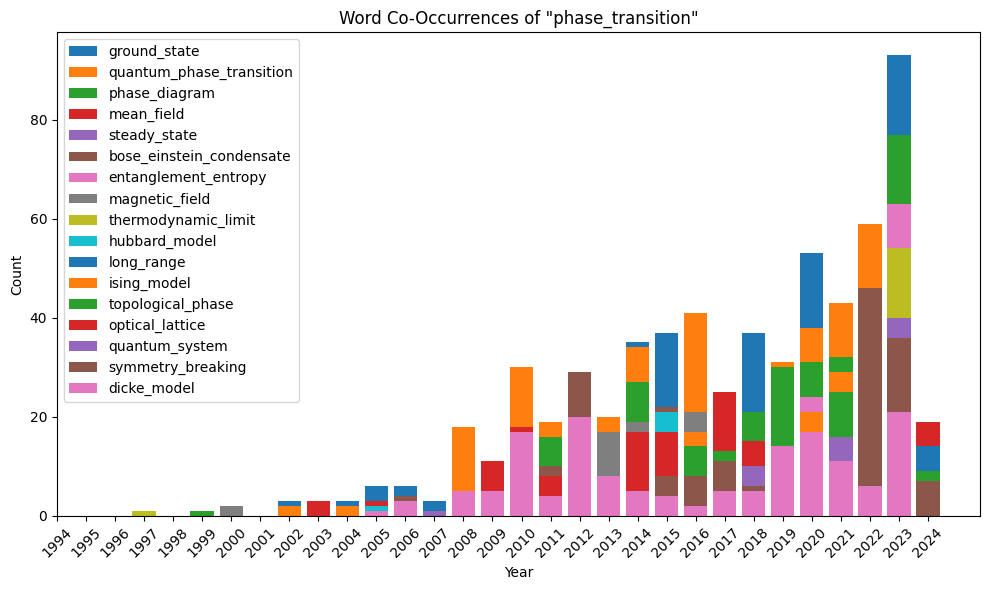

In [18]:
d = word_co_occurrences["phase_transition"]
plt.figure(figsize=(10, 6))

for cnt,k in enumerate(sorted(d, key=lambda k: len(d[k]), reverse=True)):
    print (k,len(d[k]))

    year_counts = Counter(d[k])
    unique_years = list(year_counts.keys())
    counts = list(year_counts.values())
    plt.bar(unique_years, counts,label=k)
    if cnt > 15:
        break 


plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Word Co-Occurrences of "phase_transition"')
plt.xticks(np.unique(year_arr), rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()

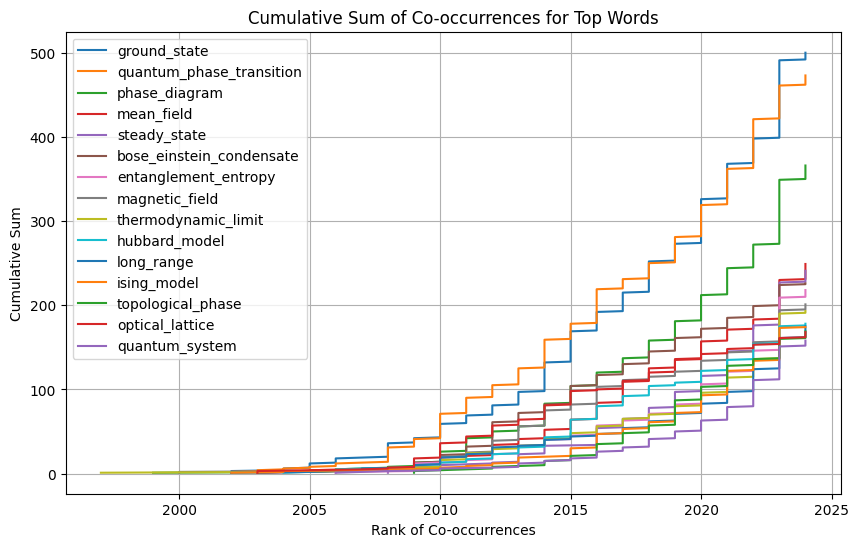

In [10]:
plt.figure(figsize=(10, 6))

# Sort the dictionary based on the length of co-occurrences
sorted_keys = sorted(d, key=lambda k: len(d[k]), reverse=True)

# Plot up to the top 15 words with the highest co-occurrence counts
for k in sorted_keys[:15]:
    plt.plot(sorted(d[k]), np.cumsum(np.ones_like(sorted(d[k]))),label=k)

# Set plot labels and title
plt.xlabel('Rank of Co-occurrences')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Co-occurrences for Top Words')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Investigate Increasing Sim and Co-Occur:

In [11]:
for k in list(word_co_occurrences["phase_transition"].keys()):
    print(k)

quantum_system
qubit_nuclear_magnetic_resonance
quantum_information_processor
spin_selective_excitation
quantum_correlation
quantum_information
resolved_spectroscopy
photonic_band_gap
superconducting_gap
symmetry_breaking_transition
gravitational_wave
spectral_evolution
color_center
nuclear_transition
photon_bound_state
energy_distribution
quantum_state
negative_energy
ground_state
quantum_phase_transition
excitation_spectrum
excited_state
eigenvalue_spectrum
wave_function
excited_state_quantum_phase_transition
finite_size_scaling_behavior
mean_field
fermionic_model
pairing_interaction
spin_model
toric_code
exact_ground_state
coupling_constant
topological_entropy
thermal_phase_transition
bcs_theory
mixed_state
response_function
heat_capacity
geometric_phase
quantum_spin_chain
translation_invariant
xy_model
von_neumann_entropy
toeplitz_matrix
matrix_function
theta_function
hyperelliptic_curve
unit_circle
quantum_critical_system
quantum_limit
tight_binding
pair_creation
cluster_state
qua

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Define a function to calculate cosine similarity
def similarity_cosine(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

import pandas as pd 
increase_total_df = pd.read_csv("/home/felix/Downloads/top_increase_total_concepts.csv")
co_occur_arr = []
final_arr = []

for index, row in increase_total_df.iterrows():
    c1 = row.to_numpy()[1]
    c2 = row.to_numpy()[2]
    
    try:
        co_dict = word_co_occurrences[c1][c2]
        co_occur_arr.append(len(co_dict)) 
        encoding1 = c_reduced_dict[c1]
        encoding2 = c_reduced_dict[c2]
        encoding1 = np.array([encoding1[str(i)] for i in np.unique(year_arr)])
        encoding2 = np.array([encoding2[str(i)] for i in np.unique(year_arr)])
        # # Compute cosine similarity
        similarity_per_year = np.array([similarity_cosine(v1, v2) for (v1, v2) in zip(encoding1, encoding2)])
        final_arr.append(similarity_per_year[-1])
    except:
        co_occur_arr.append(0)
        final_arr.append(0) 


increase_total_df["co_count"] = co_occur_arr
increase_total_df["final"] = final_arr
df_sorted = increase_total_df.sort_values(by=['co_count',"0"])
df_sorted.head()

df_sorted.to_csv("top_increase_total_concepts_co.csv")




# for cnt, c_1 in tqdm(enumerate(concept_inx_arr)):
#     for c_2 in concept_inx_arr[cnt:]:

    
    # relative_change = distance_change / similarity_per_year[0] if similarity_per_year[0] != 0 else 0
    
    


    
#        

In [ ]:
df_sorted.head()

,0,1,2,co_count,final
995,0.603941,cliffordt_circuit,controllednot_gate,0,0.0
994,0.604026,displaced_squeezed,optical_parametric,0,0.0
990,0.604063,continuous_wave,superluminescent_diode,0,0.0
987,0.604480,multifractal_dimension,periodic_orbit,0,0.0
985,0.604521,pol_oscillator,waals_interaction,0,0.0


In [ ]:
increase_total_df = pd.read_csv("/home/felix/Downloads/top_decrease_total_concepts.csv")
co_occur_arr = []
final_arr = []

for index, row in increase_total_df.iterrows():
    c1 = row.to_numpy()[1]
    c2 = row.to_numpy()[2]
    
    try:
        co_dict = word_co_occurrences[c1][c2]
        co_occur_arr.append(len(co_dict))
        encoding1 = c_reduced_dict[c1]
        encoding2 = c_reduced_dict[c2]
        encoding1 = np.array([encoding1[str(i)] for i in np.unique(year_arr)])
        encoding2 = np.array([encoding2[str(i)] for i in np.unique(year_arr)])
        # # Compute cosine similarity
        similarity_per_year = np.array([similarity_cosine(v1, v2) for (v1, v2) in zip(encoding1, encoding2)])
        final_arr.append(similarity_per_year[-1]) 
    except:
        co_occur_arr.append(0)
        final_arr.append(0)  


increase_total_df["co_count"] = co_occur_arr
increase_total_df["final"] = final_arr
df_sorted = increase_total_df.sort_values(by=['co_count',"0"])
df_sorted.head()

df_sorted.to_csv("top_decrease_total_concepts_co.csv")

In [ ]:
increase_total_df = pd.read_csv("/home/felix/Downloads/top_increase_relative_concepts.csv")
co_occur_arr = []
final_arr = []

for index, row in increase_total_df.iterrows():
    c1 = row.to_numpy()[1]
    c2 = row.to_numpy()[2]
    
    try:
        co_dict = word_co_occurrences[c1][c2]
        co_occur_arr.append(len(co_dict))
        encoding1 = c_reduced_dict[c1]
        encoding2 = c_reduced_dict[c2]
        encoding1 = np.array([encoding1[str(i)] for i in np.unique(year_arr)])
        encoding2 = np.array([encoding2[str(i)] for i in np.unique(year_arr)])
        # # Compute cosine similarity
        similarity_per_year = np.array([similarity_cosine(v1, v2) for (v1, v2) in zip(encoding1, encoding2)])
        final_arr.append(similarity_per_year[-1]) 
    except:
        co_occur_arr.append(0)
        final_arr.append(0)  


increase_total_df["co_count"] = co_occur_arr
increase_total_df["final"] = final_arr
df_sorted = increase_total_df.sort_values(by=['co_count',"0"])
df_sorted.head()

df_sorted.to_csv("top_increase_relative_concepts_co.csv")

In [ ]:
increase_total_df = pd.read_csv("/home/felix/Downloads/top_decrease_relative_concepts.csv")
co_occur_arr = []
final_arr = []

for index, row in increase_total_df.iterrows():
    c1 = row.to_numpy()[1]
    c2 = row.to_numpy()[2]
    
    try:
        co_dict = word_co_occurrences[c1][c2]
        co_occur_arr.append(len(co_dict))
        encoding1 = c_reduced_dict[c1]
        encoding2 = c_reduced_dict[c2]
        encoding1 = np.array([encoding1[str(i)] for i in np.unique(year_arr)])
        encoding2 = np.array([encoding2[str(i)] for i in np.unique(year_arr)])
        # # Compute cosine similarity
        similarity_per_year = np.array([similarity_cosine(v1, v2) for (v1, v2) in zip(encoding1, encoding2)])
        final_arr.append(similarity_per_year[-1]) 
    except:
        co_occur_arr.append(0)
        final_arr.append(0)  


increase_total_df["co_count"] = co_occur_arr
increase_total_df["final"] = final_arr
df_sorted = increase_total_df.sort_values(by=['co_count',"0"])
df_sorted.head()

df_sorted.to_csv("top_decrease_relative_concepts_co.csv")

In [ ]:
# import pandas as pd

# df = pd.DataFrame(top_increase_total_concepts)


# df.to_csv("file_path.csv", index=False)

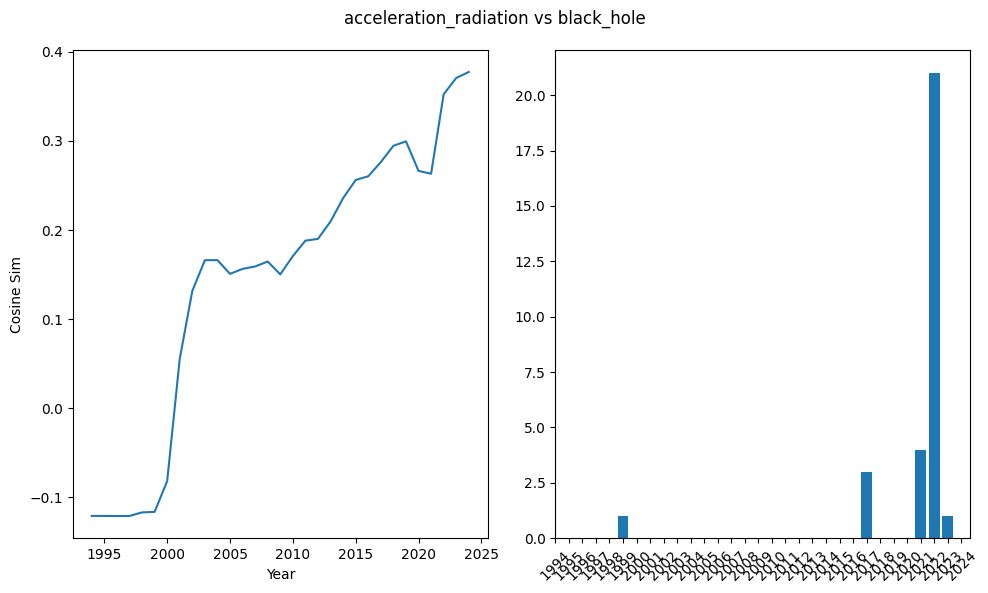

In [ ]:

found = False
sim_save_arr = []
while not found:
    c1=np.random.choice(concept_inx_arr)
    c2=np.random.choice(concept_inx_arr)

    zx_d = c_dict[c1]
    su_d = c_dict[c2]

    track_vec_bell_inequality = np.array([zx_d[str(i)] for i in np.unique(year_arr)])
    track_vec_schroding_equation = np.array([su_d[str(i)] for i in np.unique(year_arr)])

    def similarity_cosine(vec1, vec2):
        cosine_similarity = np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))
        return cosine_similarity

    sim_arr = [similarity_cosine(v1, v2) for (v1,v2) in zip(track_vec_bell_inequality,track_vec_schroding_equation)]

    slope, intercept = np.polyfit(np.arange(31), sim_arr, deg=1)
    
    sim_save_arr.append(sim_arr)
    if slope > 0 and c2 in word_co_occurrences[c1]:
        if len(word_co_occurrences[c1][c2])>10:
            found = True 
        
year_counts = Counter(word_co_occurrences[c1][c2])
unique_years = list(year_counts.keys())
counts = list(year_counts.values())
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[1].bar(unique_years, counts)
axs[0].plot(np.unique(year_arr),sim_arr)

axs[0].set_ylabel("Cosine Sim")
axs[0].set_xlabel("Year")

axs[1].set_xticks(np.unique(year_arr),np.unique(year_arr), rotation=45) 

fig.suptitle(c1 + " vs "+c2)
fig.tight_layout()

Top changes in sim

In [ ]:
# top_increase_total_concepts = []
# top_decrease_total_concepts = []

# top_increase_relative_concepts = []
# top_decrease_relative_concepts = []


# for cnt, c_1 in tqdm(enumerate(concept_inx_arr)):
    
#     for c_2 in concept_inx_arr[cnt:]:

        
#         encoding1 = c_reduced_dict[c_1]
#         encoding2 = c_reduced_dict[c_2]
#         encoding1 = np.array([encoding1[str(i)] for i in np.unique(year_arr)])
#         encoding2 = np.array([encoding2[str(i)] for i in np.unique(year_arr)])

#         # Compute label: 1 if concepts are similar, 0 otherwise
#         similarity_per_year = [similarity_cosine(v1, v2) for (v1,v2) in zip(encoding1,encoding2)]

#         distance_change = similarity_per_year[-1] - similarity_per_year[0]
#         relative_change = distance_change / similarity_per_year[0]  # Relative change

#         # Update top increase/decrease concepts if applicable
#         if len(top_increase_total_concepts) < 100:
#             top_increase_total_concepts.append((c_1, c_2, distance_change))
#             top_decrease_total_concepts.append((c_1, c_2, distance_change))

#             top_increase_relative_concepts.append((c_1, c_2, relative_change)) 
#             top_decrease_relative_concepts.append((c_1, c_2, relative_change))

#         else:
#             top_increase_total_concepts.sort(key=lambda x: x[2], reverse=True)
#             top_decrease_total_concepts.sort(key=lambda x: x[2])
#             top_increase_relative_concepts.sort(key=lambda x: x[2], reverse=True)
#             top_decrease_relative_concepts.sort(key=lambda x: x[2])
            
            
#             if distance_change > top_increase_total_concepts[-1][2]:
#                 top_increase_total_concepts[-1] = (c_1, c_2, distance_change)

#             if distance_change < top_decrease_total_concepts[-1][2]:
#                 top_decrease_total_concepts[-1] = (c_1, c_2, distance_change)

#             if relative_change > top_increase_relative_concepts[-1][2]:
#                 top_increase_relative_concepts[-1] = (c_1, c_2, relative_change)

#             if relative_change < top_decrease_relative_concepts[-1][2]:
#                 top_decrease_relative_concepts[-1] = (c_1, c_2, relative_change)
                

In [ ]:
# # Print top 10 concepts with the largest increase and decrease in distance
# print("Top 10 concepts with the largest total increase in distance:")
# for concept in top_increase_total_concepts:
#     print(f"Concept pair: {concept[1]}, {concept[2]}, Distance change: {concept[0]:.2f}")

# print("\nTop 10 concepts with the largest total decrease in distance:")
# for concept in top_decrease_total_concepts:
#     print(f"Concept pair: {concept[1]}, {concept[2]}, Distance change: {concept[0]:.2f}")


In [ ]:
# # Print top 10 concepts with the largest increase and decrease in distance
# print("Top 10 concepts with the largest relative increase in distance:")
# for concept in top_increase_relative_concepts:
#     print(f"Concept pair: {concept[1]}, {concept[2]}, Distance change: {concept[0]:.2f}")

# print("\nTop 10 concepts with the largest relative decrease in distance:")
# for concept in top_decrease_relative_concepts:
#     print(f"Concept pair: {concept[1]}, {concept[2]}, Distance change: {concept[0]:.2f}")
